In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'Order_items')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='pass123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/ASUS/Desktop/Ecommerce Project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector 
import numpy as np 
db = mysql.connector.connect(host='localhost',
username = 'root',
password = 'pass123',
database = 'ecommerce')


cur = db.cursor()



# 1. List all unique cities where customers are located.

In [4]:
query = """select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data)

df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [7]:
query = """select count(Order_id) from orders 
where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total Orders Placed in 2017 are", data[0][0]

('Total Orders Placed in 2017 are', 45101)

# 3. Find the total sales per category.

In [14]:
query = """select Upper(p.product_category) as category, 
round(sum(pa.payment_value),2) as Sales from products p 
join order_items o on p.product_id = o.product_id
join payments pa on o.order_id = pa.order_id
group by category; """

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Category","Sales"])

df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# 4. Calculate the percentage of orders that were paid in installments.

In [21]:
query = """select sum(case when payment_installments >=1 then 1 else 0 end)/count(0)*100 as Percentage 
from payments; """

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

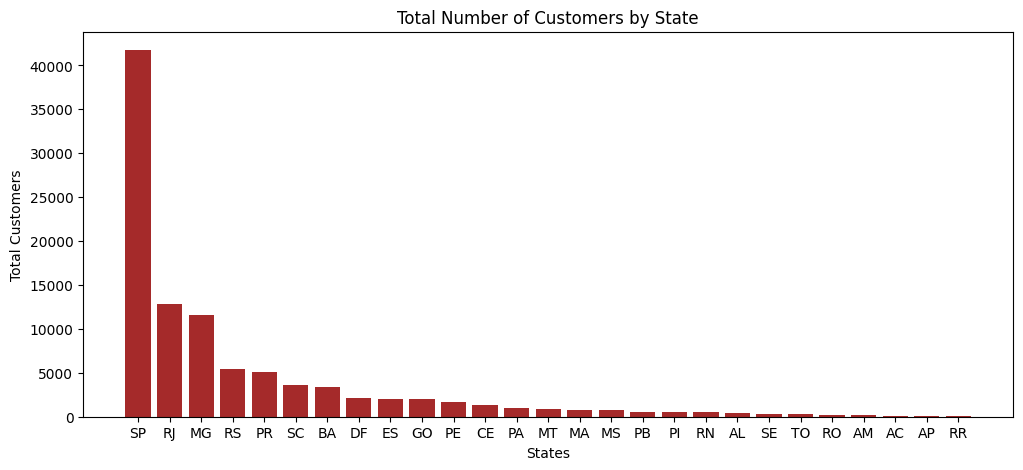

In [ ]:
query = """select customer_state,
count(customer_id) as total_count from customers
group by customer_state; """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns=["State","Total Customers"])
df= df.sort_values(by = "Total Customers", ascending= False)
df

plt.figure(figsize=(12, 5))
plt.xlabel("States")
plt.ylabel("Total Customers")
plt.bar(df["State"],df["Total Customers"],color="brown")
plt.title("Total Number of Customers by State")
plt.show()

# 6. Calculate the number of orders per month in 2018.

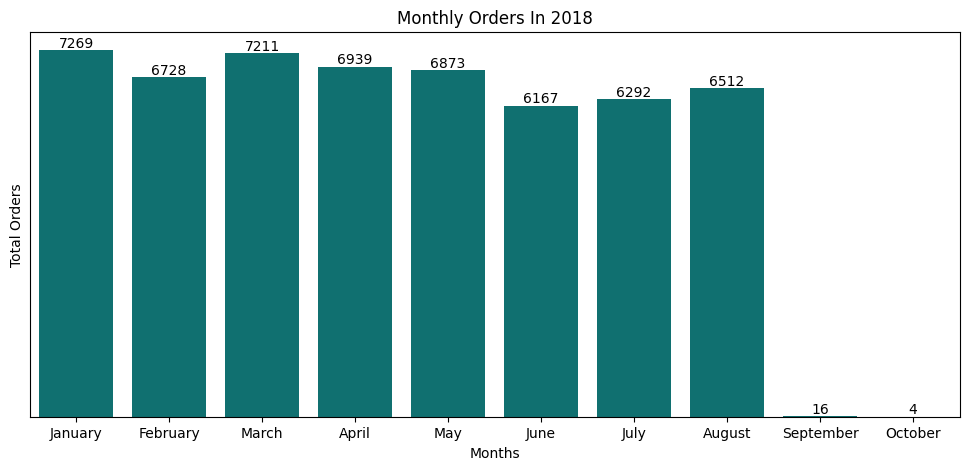

In [ ]:
query = """select monthname(order_purchase_timestamp) as Month,
count(order_id) as "Total Orders" from orders 
where year(order_purchase_timestamp) = 2018
group by Month ; """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data,columns=["Months","Total Orders"])
df

o=["January","February","March","April","May","June","July","August","September","October"]

plt.figure(figsize=(12, 5))
ax=sns.barplot(x= df["Months"],y= df["Total Orders"],order = o,color="teal")
plt.xlabel("Months")
plt.ylabel("Total Orders")
plt.title("Monthly Orders In 2018")
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [47]:
query = """with count_per_order as (select orders.order_id as order_id,orders.customer_id as customer_id,count(order_items.order_id) as order_counts
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.order_counts),2) as avg_orders from customers 
join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by avg_orders desc; """

cur.execute(query)

data = cur.fetchall()

data

df =pd.DataFrame(data,columns=['Customer City','Avg Product/Order'])
df.head(10)

,Customer City,Avg Product/Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [51]:
query = """select p.product_category as category, 
round((sum(pa.payment_value)/(select sum(payment_value) from payments))*100,2) as Sales_percentage 
from products p 
join order_items o on p.product_id = o.product_id
join payments pa on o.order_id = pa.order_id
group by category
order by Sales_percentage desc; """

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Category","Percentage Distribution"])

df.head(10)

,Category,Percentage Distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# 9. Identify the correlation between product price and the 
# number of times a product has been purchased.

In [66]:
query = """select products.product_category as Category,
count(order_items.product_id) as "Total Counts",
round(avg(Order_items.price),2) as "Average Price" 
from Products 
join Order_items on products.product_id = Order_items.product_id
group by Category ;
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Category","Total Orders","Average Price"])

df.head(10)

arr1 = df["Total Orders"]
arr2 = df["Average Price"]
a = np.corrcoef([arr1,arr2])
print("The Correlation is",a[0][-1])

The Correlation is -0.10631514167157562


# 10. Calculate the total revenue generated 
# by each seller, and rank them by revenue.

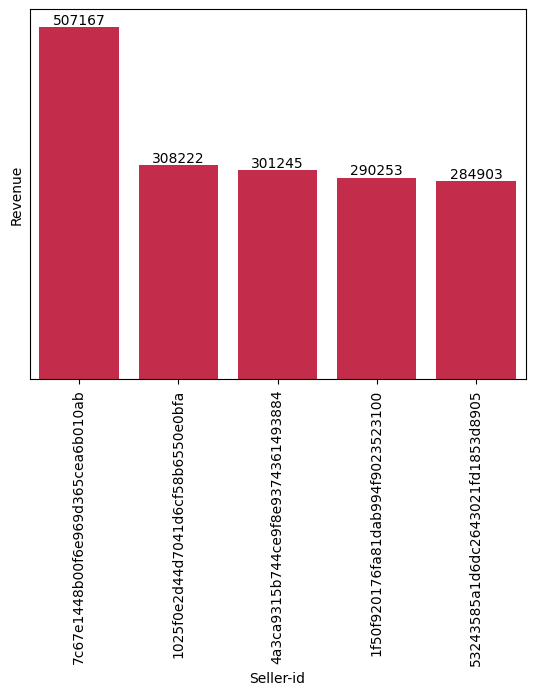

In [98]:
query = """
select *,dense_rank() over(order by revenue desc) as "Rank" from 
(select order_items.seller_id,sum(payments.payment_value) as Revenue from order_items 
join payments on order_items.order_id = payments.order_id
group by order_items.seller_id) as a;
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Seller-id","Revenue","Rank"])
df= df.head()
ax= sns.barplot(x=df["Seller-id"],y=df["Revenue"],color="crimson")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.yticks([])
plt.show()

# 11. Calculate the moving average of order values for 
# each customer over their order history.

In [102]:
query = """
select customer_id,order_purchase_timestamp,payments,
avg(payments) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id ,orders.order_purchase_timestamp,payments.payment_value as payments from payments 
join orders on payments.order_id = orders.order_id) as a
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Customer id","Timestamp","Payment","Moving Avg"])
df

,Customer id,Timestamp,Payment,Moving Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# 12. Calculate the cumulative sales per month for each year.

In [ ]:
query = """
select years,months,payments,
sum(payments) over(order by years,months)  as cum_Sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments from orders
join payments on orders.order_id = payments.order_id
group by years,months 
order by years,months) as a;
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Years","Months","Payment","Cumulative sum"])
df



,Years,Months,Payment,Cumulative sum
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# 13. Calculate the year-over-year growth rate of total sales.

In [10]:
query = """
with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payments from orders
join payments on orders.order_id = payments.order_id
group by years 
order by years)
select years,payments,lag(payments,1) over(order by years) as previous_year,
round(((payments-lag(payments,1) over(order by years))/lag(payments,1) over(order by years))*100,2) as "Growth rate" from a;
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Years",'Sales','Previous_year','YOY Growth Rate %'])
df

,Years,Sales,Previous_year,YOY Growth Rate %
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


# 14. Identify the top 3 customers who spent the most money in each year.

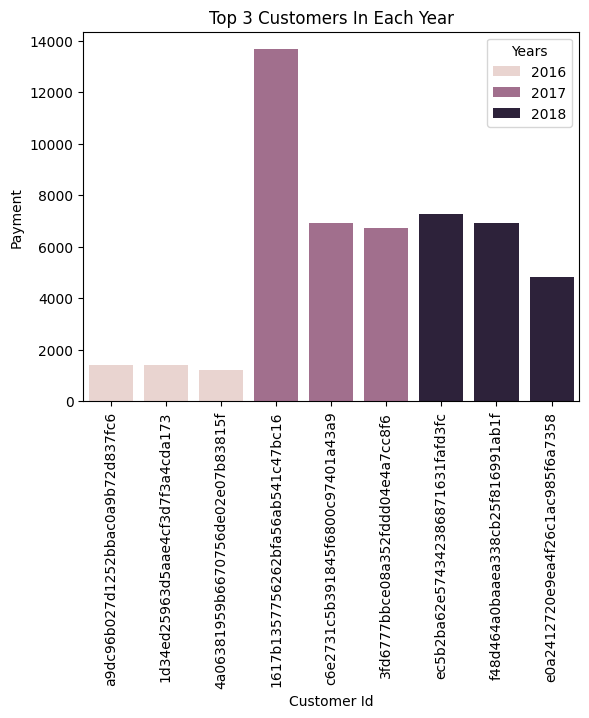

In [19]:
query = """
select years,customer_id,payment,d_rank from
(select year(orders.order_purchase_timestamp) as years,orders.customer_id,sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank	
from orders join payments
on orders.order_id = payments.order_id 
group by years,orders.customer_id) as a
where d_rank <=3;
"""

cur.execute(query)

data = cur.fetchall()

data

df= pd.DataFrame(data,columns=["Years","Customer Id",'Payment','Rank'])

sns.barplot(x= "Customer Id",y= "Payment", data = df, hue ='Years')
plt.title("Top 3 Customers In Each Year")
plt.xticks(rotation = 90)

plt.show()
